In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import ultralytics
import matplotlib.pyplot as plt
from collections import Counter
from ultralytics import YOLO

# Extract, Transform, and Load (ETL) Process

## Extract Data from Kaggle Dataset

In [5]:
# Download dataset from kaggle
!kaggle datasets download -d achmatim/indonesian-wayang-traditional-puppet-show --force

Dataset URL: https://www.kaggle.com/datasets/achmatim/indonesian-wayang-traditional-puppet-show
License(s): apache-2.0




  0%|          | 0.00/765M [00:00<?, ?B/s]
  0%|          | 1.00M/765M [00:01<15:12, 877kB/s]
  0%|          | 2.00M/765M [00:01<08:16, 1.61MB/s]
  0%|          | 3.00M/765M [00:01<06:01, 2.21MB/s]
  1%|          | 4.00M/765M [00:02<05:40, 2.34MB/s]
  1%|          | 5.00M/765M [00:02<05:33, 2.39MB/s]
  1%|          | 6.00M/765M [00:02<04:35, 2.88MB/s]
  1%|          | 7.00M/765M [00:02<03:54, 3.39MB/s]
  1%|1         | 8.00M/765M [00:03<03:24, 3.88MB/s]
  1%|1         | 9.00M/765M [00:03<03:07, 4.23MB/s]
  1%|1         | 10.0M/765M [00:03<03:01, 4.36MB/s]
  1%|1         | 11.0M/765M [00:03<03:04, 4.28MB/s]
  2%|1         | 12.0M/765M [00:04<03:01, 4.34MB/s]
  2%|1         | 13.0M/765M [00:04<03:06, 4.23MB/s]
  2%|1         | 14.0M/765M [00:04<02:55, 4.48MB/s]
  2%|1         | 15.0M/765M [00:04<02:56, 4.46MB/s]
  2%|2         | 16.0M/765M [00:04<02:49, 4.63MB/s]
  2%|2         | 17.0M/765M [00:05<02:56, 4.43MB/s]
  2%|2         | 18.0M/765M [00:05<02:51, 4.57MB/s]
  2%|2         | 19.0

In [28]:
# Load Dataset
with zipfile.ZipFile('indonesian-wayang-traditional-puppet-show.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

print(os.listdir('./data/labeled-indonesian-wayang'))

['abimanyu', 'anoman', 'arjuna', 'bagong', 'baladewa', 'bima', 'buta', 'cakil', 'durna', 'dursasana', 'duryudana', 'gareng', 'gatotkaca', 'karna', 'kresna', 'nakula_sadewa', 'patih_sabrang', 'petruk', 'puntadewa', 'semar', 'sengkuni', 'togog']


In [1]:
# Path to the directory containing the dataset
data_dir = './data/labeled-indonesian-wayang'

# Get the list of all subdirectories (each representing a class)
classes = os.listdir(data_dir)

NameError: name 'os' is not defined

In [5]:
# Initialize a counter to store the number of images per class
class_counts = Counter()

# Iterate over each class directory
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        # Count the number of images in each class directory
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Print the distribution of images per class
print("Data Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

Data Distribution:
abimanyu: 256 images
anoman: 352 images
arjuna: 400 images
bagong: 384 images
baladewa: 400 images
bima: 336 images
buta: 368 images
cakil: 304 images
durna: 192 images
dursasana: 288 images
duryudana: 304 images
gareng: 192 images
gatotkaca: 320 images
karna: 256 images
kresna: 368 images
nakula_sadewa: 192 images
patih_sabrang: 272 images
petruk: 320 images
puntadewa: 272 images
semar: 352 images
sengkuni: 256 images
togog: 192 images


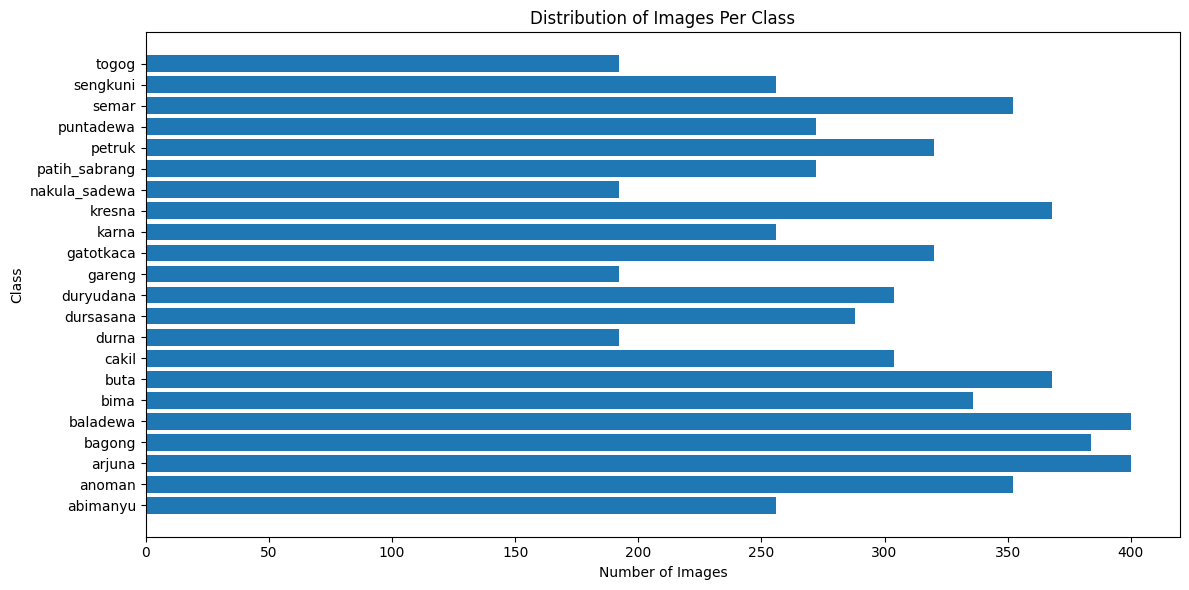

In [4]:
# Plot the distribution using a horizontal bar chart
plt.figure(figsize=(12, 6))
plt.barh(list(class_counts.keys()), list(class_counts.values()))
plt.ylabel('Class')
plt.xlabel('Number of Images')
plt.title('Distribution of Images Per Class')
plt.tight_layout()
plt.show()


In [5]:
# Show images extension
extensions = set()
for root, dirs, files in os.walk(data_dir):
    for file in files:
        _, ext = os.path.splitext(file)
        extensions.add(ext)


print(extensions)

{'.jpg', '.JPG'}


## Transform Data

In [8]:
# Define paths
train_dir = './data/train'
val_dir = './data/validation'
test_dir = './data/test'

In [27]:

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split data into train, validation, and test sets
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    images = os.listdir(class_path)

    # Create class subdirectories in train, validation, and test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Split into train and temp (validation + test) by 7:3 ratio
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    # Split temp into validation and test by 50% each
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Copy images to respective directories
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

In [11]:
# Check the number of images each directory after splitting
num_train_images_per_class = {}
num_val_images_per_class = {}
num_test_images_per_class = {}

for class_name in classes:
    num_train_images_per_class[class_name] = len(os.listdir(os.path.join(train_dir, class_name)))
    num_val_images_per_class[class_name] = len(os.listdir(os.path.join(val_dir, class_name)))
    num_test_images_per_class[class_name] = len(os.listdir(os.path.join(test_dir, class_name)))

In [12]:
# Print the results
print("Number of training images per class:", num_train_images_per_class)
print("Number of validation images per class:", num_val_images_per_class)
print("Number of test images per class:", num_test_images_per_class)

Number of training images per class: {'abimanyu': 179, 'anoman': 246, 'arjuna': 280, 'bagong': 268, 'baladewa': 280, 'bima': 235, 'buta': 257, 'cakil': 212, 'durna': 134, 'dursasana': 201, 'duryudana': 212, 'gareng': 134, 'gatotkaca': 224, 'karna': 179, 'kresna': 257, 'nakula_sadewa': 134, 'patih_sabrang': 190, 'petruk': 224, 'puntadewa': 190, 'semar': 246, 'sengkuni': 179, 'togog': 134}
Number of validation images per class: {'abimanyu': 38, 'anoman': 53, 'arjuna': 60, 'bagong': 58, 'baladewa': 60, 'bima': 50, 'buta': 55, 'cakil': 46, 'durna': 29, 'dursasana': 43, 'duryudana': 46, 'gareng': 29, 'gatotkaca': 48, 'karna': 38, 'kresna': 55, 'nakula_sadewa': 29, 'patih_sabrang': 41, 'petruk': 48, 'puntadewa': 41, 'semar': 53, 'sengkuni': 38, 'togog': 29}
Number of test images per class: {'abimanyu': 39, 'anoman': 53, 'arjuna': 60, 'bagong': 58, 'baladewa': 60, 'bima': 51, 'buta': 56, 'cakil': 46, 'durna': 29, 'dursasana': 44, 'duryudana': 46, 'gareng': 29, 'gatotkaca': 48, 'karna': 39, 'k

### Visualize the distribution of images across different classes.

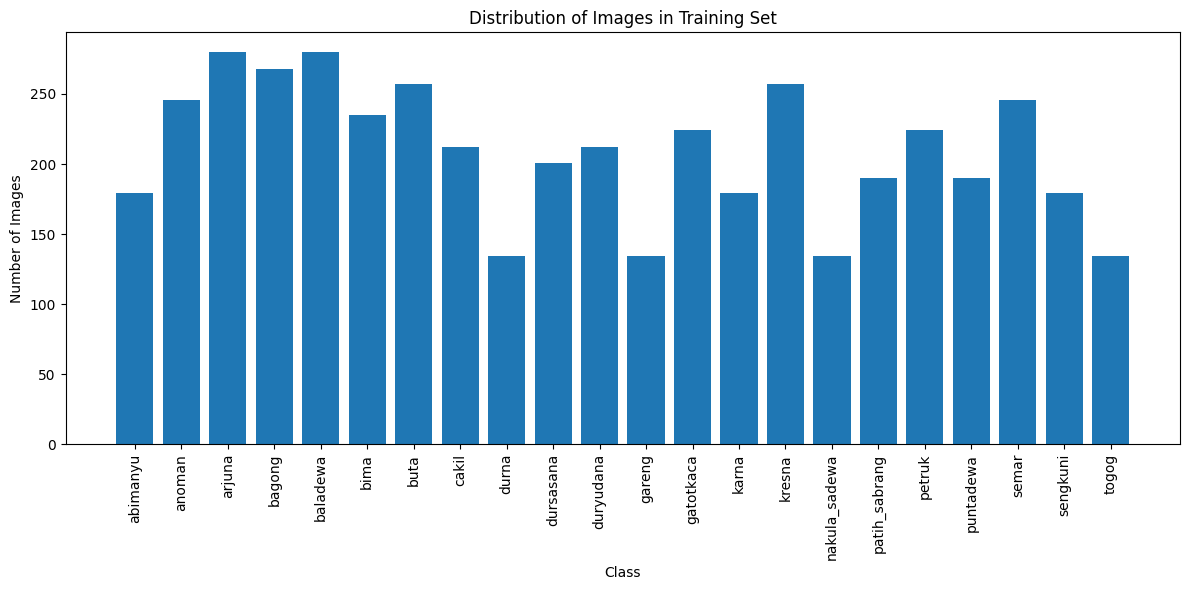

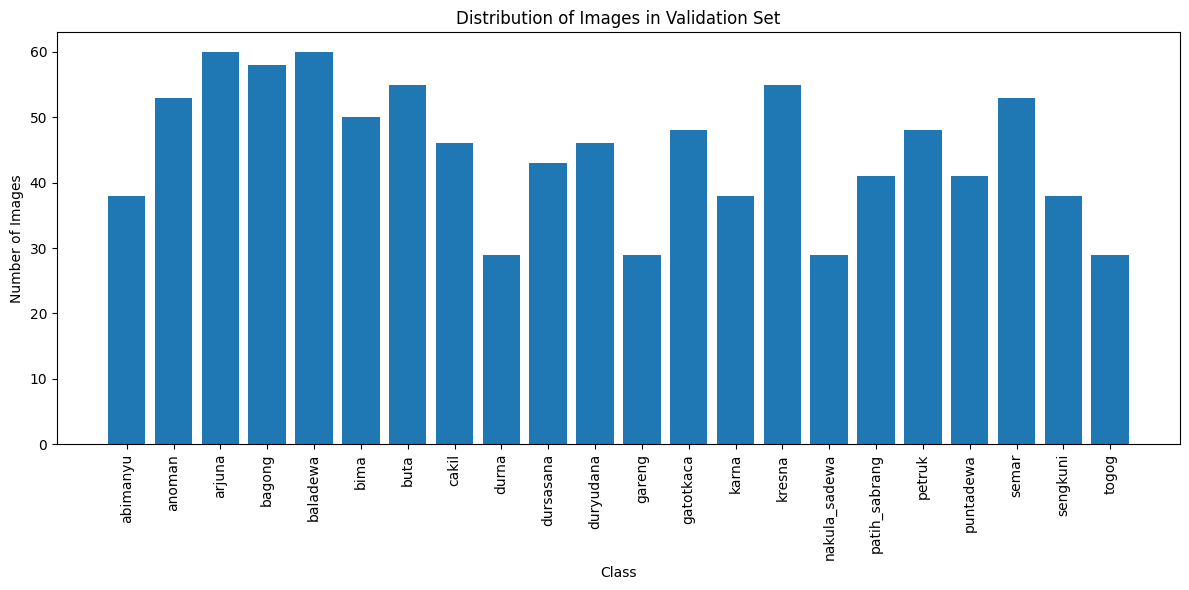

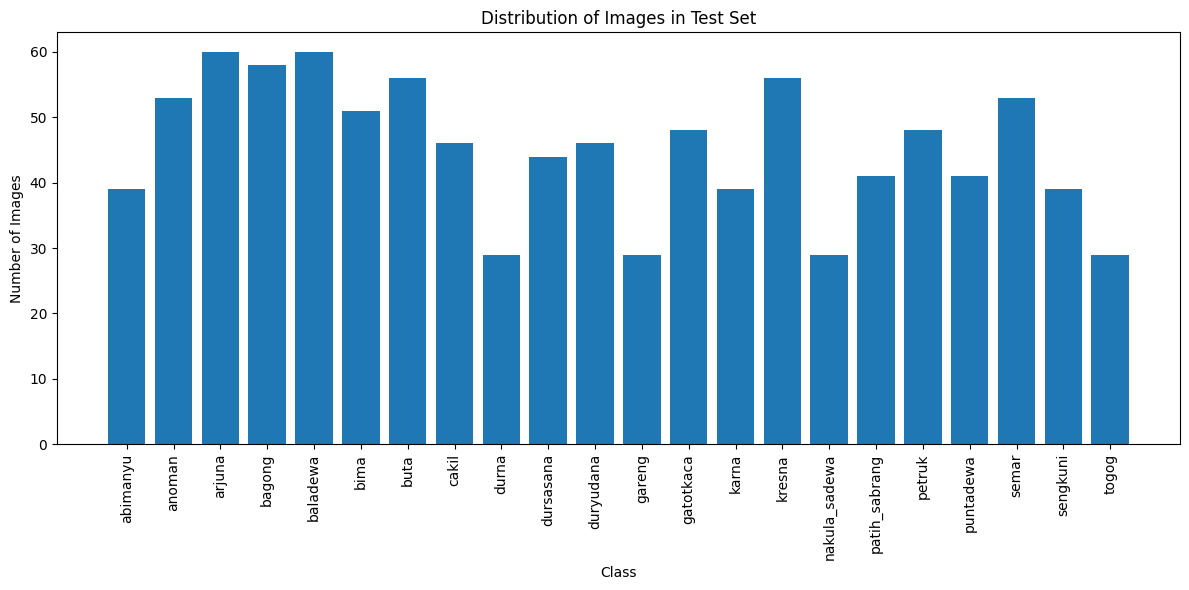

In [3]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Define paths to the directories
train_dir = './data/train'
val_dir = './data/validation'
test_dir = './data/test'

# Function to count images in each class directory
def count_images_in_directory(directory):
    class_counts = Counter()
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts

# Count images in each split
train_counts = count_images_in_directory(train_dir)
val_counts = count_images_in_directory(val_dir)
test_counts = count_images_in_directory(test_dir)

# Plot the distribution
def plot_distribution(counts, title):
    plt.figure(figsize=(12, 6))
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Plot distributions for each dataset split
plot_distribution(train_counts, 'Distribution of Images in Training Set')
plot_distribution(val_counts, 'Distribution of Images in Validation Set')
plot_distribution(test_counts, 'Distribution of Images in Test Set')

In [2]:
# Load the pre-trained model
base_model = YOLO("yolo11n-cls.pt")

In [3]:
base_model.model

ClassificationModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
  

In [4]:
# Train the model without freezing any layers
unfreeze_model = base_model.train(
    data="./data",  # path to data file/folder
    name="unfreeze-all",
    epochs=100,
    imgsz=224,
    batch=-1,
    optimizer="AdamW",
    patience=5,
    amp=True,
    val=True,
    plots=True
)

New https://pypi.org/project/ultralytics/8.3.107 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.49  Python-3.11.0 torch-2.5.1+cpu CPU (12th Gen Intel Core(TM) i7-12650H)
engine\trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=./data, epochs=100, time=None, patience=5, batch=-1, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=unfreeze-all, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames

train: Scanning C:\Users\Pongo\PycharmProjects\JupyterProject\data\train... 4595 images, 0 corrupt: 100%|██████████| 4595/4595 [00:00<?, ?it/s]

train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\abimanyu\abimanyu002.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\abimanyu\abimanyu003.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\anoman\anoman012.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\anoman\anoman013.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\anoman\anoman014.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\anoman\anoman017.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\anoman\anoman021.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\anoman\anoman022.jpg: corrupt 


val: Scanning C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation... 987 images, 0 corrupt: 100%|██████████| 987/987 [00:00<?, ?it/s]

val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\abimanyu\abimanyu015.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\anoman\anoman003c.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\anoman\anoman015.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\anoman\anoman016.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\anoman\anoman020.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\arjuna\arjuna008.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\arjuna\arjuna016.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\arjuna\ar

TensorBoard: model graph visualization added 
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs\classify\unfreeze-all
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100         0G      2.393          3        224: 100%|██████████| 288/288 [05:49<00:00,  1.21s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:20<00:00,  1.48it/s]

                   all      0.283      0.745



      Epoch    GPU_mem       loss  Instances       Size


      2/100         0G      2.294          3        224: 100%|██████████| 288/288 [06:09<00:00,  1.28s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:41<00:00,  1.32s/it]

                   all       0.22      0.622



      Epoch    GPU_mem       loss  Instances       Size


      3/100         0G      2.085          3        224: 100%|██████████| 288/288 [05:59<00:00,  1.25s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:19<00:00,  1.58it/s]

                   all      0.419      0.821



      Epoch    GPU_mem       loss  Instances       Size


      4/100         0G      1.822          3        224: 100%|██████████| 288/288 [03:28<00:00,  1.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]

                   all      0.515      0.917



      Epoch    GPU_mem       loss  Instances       Size


      5/100         0G      1.616          3        224: 100%|██████████| 288/288 [07:28<00:00,  1.56s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:39<00:00,  1.26s/it]

                   all      0.624      0.934



      Epoch    GPU_mem       loss  Instances       Size


      6/100         0G      1.361          3        224: 100%|██████████| 288/288 [05:11<00:00,  1.08s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:19<00:00,  1.58it/s]

                   all      0.684      0.972



      Epoch    GPU_mem       loss  Instances       Size


      7/100         0G      1.256          3        224: 100%|██████████| 288/288 [03:42<00:00,  1.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:33<00:00,  1.07s/it]

                   all      0.753      0.983



      Epoch    GPU_mem       loss  Instances       Size


      8/100         0G        1.1          3        224: 100%|██████████| 288/288 [03:20<00:00,  1.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:19<00:00,  1.58it/s]

                   all      0.812      0.981



      Epoch    GPU_mem       loss  Instances       Size


      9/100         0G     0.9898          3        224: 100%|██████████| 288/288 [03:22<00:00,  1.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:10<00:00,  2.84it/s]

                   all      0.801      0.984



      Epoch    GPU_mem       loss  Instances       Size


     10/100         0G     0.8952          3        224: 100%|██████████| 288/288 [01:44<00:00,  2.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:11<00:00,  2.61it/s]

                   all      0.858      0.989



      Epoch    GPU_mem       loss  Instances       Size


     11/100         0G     0.8891          3        224: 100%|██████████| 288/288 [01:51<00:00,  2.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:12<00:00,  2.45it/s]

                   all      0.865      0.991



      Epoch    GPU_mem       loss  Instances       Size


     12/100         0G     0.7894          3        224: 100%|██████████| 288/288 [01:54<00:00,  2.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:14<00:00,  2.17it/s]

                   all      0.869      0.994



      Epoch    GPU_mem       loss  Instances       Size


     13/100         0G     0.7523          3        224: 100%|██████████| 288/288 [02:16<00:00,  2.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:18<00:00,  1.64it/s]

                   all      0.924      0.996



      Epoch    GPU_mem       loss  Instances       Size


     14/100         0G     0.6534          3        224: 100%|██████████| 288/288 [02:28<00:00,  1.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]

                   all      0.909      0.999



      Epoch    GPU_mem       loss  Instances       Size


     15/100         0G     0.6512          3        224: 100%|██████████| 288/288 [02:02<00:00,  2.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.30it/s]

                   all      0.937      0.999



      Epoch    GPU_mem       loss  Instances       Size


     16/100         0G     0.5806          3        224: 100%|██████████| 288/288 [01:57<00:00,  2.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.32it/s]

                   all      0.921      0.998



      Epoch    GPU_mem       loss  Instances       Size


     17/100         0G     0.5802          3        224: 100%|██████████| 288/288 [02:04<00:00,  2.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.34it/s]

                   all      0.942      0.999



      Epoch    GPU_mem       loss  Instances       Size


     18/100         0G     0.5484          3        224: 100%|██████████| 288/288 [01:59<00:00,  2.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:12<00:00,  2.41it/s]

                   all      0.945      0.999



      Epoch    GPU_mem       loss  Instances       Size


     19/100         0G     0.5243          3        224: 100%|██████████| 288/288 [02:03<00:00,  2.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.32it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100         0G     0.5163          3        224: 100%|██████████| 288/288 [02:05<00:00,  2.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:14<00:00,  2.14it/s]

                   all      0.949          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100         0G     0.4641          3        224: 100%|██████████| 288/288 [02:07<00:00,  2.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.23it/s]

                   all      0.945      0.997



      Epoch    GPU_mem       loss  Instances       Size


     22/100         0G     0.4513          3        224: 100%|██████████| 288/288 [02:19<00:00,  2.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:14<00:00,  2.08it/s]

                   all      0.966      0.999



      Epoch    GPU_mem       loss  Instances       Size


     23/100         0G     0.4258          3        224: 100%|██████████| 288/288 [02:03<00:00,  2.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.34it/s]

                   all      0.956          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100         0G     0.3955          3        224: 100%|██████████| 288/288 [02:04<00:00,  2.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:12<00:00,  2.39it/s]

                   all      0.953      0.998



      Epoch    GPU_mem       loss  Instances       Size


     25/100         0G       0.39          3        224: 100%|██████████| 288/288 [02:02<00:00,  2.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.34it/s]

                   all      0.953      0.998



      Epoch    GPU_mem       loss  Instances       Size


     26/100         0G     0.3593          3        224: 100%|██████████| 288/288 [02:05<00:00,  2.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.36it/s]

                   all      0.967      0.998



      Epoch    GPU_mem       loss  Instances       Size


     27/100         0G     0.3582          3        224: 100%|██████████| 288/288 [02:01<00:00,  2.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.36it/s]

                   all      0.964      0.998



      Epoch    GPU_mem       loss  Instances       Size


     28/100         0G     0.3533          3        224: 100%|██████████| 288/288 [01:58<00:00,  2.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.32it/s]

                   all      0.957      0.999



      Epoch    GPU_mem       loss  Instances       Size


     29/100         0G      0.345          3        224: 100%|██████████| 288/288 [01:57<00:00,  2.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.34it/s]

                   all      0.974      0.999



      Epoch    GPU_mem       loss  Instances       Size


     30/100         0G     0.3636          3        224: 100%|██████████| 288/288 [02:05<00:00,  2.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.28it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100         0G     0.3424          3        224: 100%|██████████| 288/288 [01:59<00:00,  2.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.30it/s]

                   all      0.975      0.999



      Epoch    GPU_mem       loss  Instances       Size


     32/100         0G     0.3281          3        224: 100%|██████████| 288/288 [02:00<00:00,  2.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.32it/s]

                   all      0.971      0.999



      Epoch    GPU_mem       loss  Instances       Size


     33/100         0G     0.3131          3        224: 100%|██████████| 288/288 [01:57<00:00,  2.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:12<00:00,  2.39it/s]

                   all      0.975      0.999



      Epoch    GPU_mem       loss  Instances       Size


     34/100         0G     0.2908          3        224: 100%|██████████| 288/288 [02:17<00:00,  2.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]

                   all      0.978      0.999



      Epoch    GPU_mem       loss  Instances       Size


     35/100         0G      0.286          3        224: 100%|██████████| 288/288 [02:12<00:00,  2.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:14<00:00,  2.19it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100         0G     0.3071          3        224: 100%|██████████| 288/288 [02:19<00:00,  2.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:15<00:00,  2.04it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100         0G     0.2925          3        224: 100%|██████████| 288/288 [02:17<00:00,  2.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.34it/s]

                   all      0.979      0.999



      Epoch    GPU_mem       loss  Instances       Size


     38/100         0G     0.2593          3        224: 100%|██████████| 288/288 [02:08<00:00,  2.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.33it/s]

                   all      0.987      0.999



      Epoch    GPU_mem       loss  Instances       Size


     39/100         0G     0.2498          3        224: 100%|██████████| 288/288 [02:24<00:00,  2.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:19<00:00,  1.60it/s]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


     40/100         0G     0.2551          3        224: 100%|██████████| 288/288 [03:15<00:00,  1.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:27<00:00,  1.11it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


     41/100         0G     0.2518          3        224: 100%|██████████| 288/288 [06:43<00:00,  1.40s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:46<00:00,  1.50s/it]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


     42/100         0G      0.247          3        224: 100%|██████████| 288/288 [04:17<00:00,  1.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:16<00:00,  1.85it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


     43/100         0G     0.2187          3        224: 100%|██████████| 288/288 [02:27<00:00,  1.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:15<00:00,  2.02it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


     44/100         0G     0.2121          3        224: 100%|██████████| 288/288 [02:31<00:00,  1.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:16<00:00,  1.86it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100         0G      0.222          3        224: 100%|██████████| 288/288 [02:25<00:00,  1.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:15<00:00,  2.01it/s]

                   all      0.983      0.999



      Epoch    GPU_mem       loss  Instances       Size


     46/100         0G     0.2097          3        224: 100%|██████████| 288/288 [02:24<00:00,  2.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:17<00:00,  1.77it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


     47/100         0G     0.2035          3        224: 100%|██████████| 288/288 [02:20<00:00,  2.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:14<00:00,  2.16it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     48/100         0G     0.1966          3        224: 100%|██████████| 288/288 [02:03<00:00,  2.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.33it/s]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


     49/100         0G     0.1759          3        224: 100%|██████████| 288/288 [02:01<00:00,  2.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.30it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     50/100         0G     0.1971          3        224: 100%|██████████| 288/288 [02:01<00:00,  2.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.30it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     51/100         0G     0.1739          3        224: 100%|██████████| 288/288 [02:00<00:00,  2.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:13<00:00,  2.36it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     52/100         0G     0.1836          3        224: 100%|██████████| 288/288 [02:02<00:00,  2.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:14<00:00,  2.20it/s]

                   all      0.991          1
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 47, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



52 epochs completed in 2.650 hours.
Optimizer stripped from runs\classify\unfreeze-all\weights\last.pt, 3.2MB
Optimizer stripped from runs\classify\unfreeze-all\weights\best.pt, 3.2MB

Validating runs\classify\unfreeze-all\weights\best.pt...
Ultralytics 8.3.49  Python-3.11.0 torch-2.5.1+cpu CPU (12th Gen Intel Core(TM) i7-12650H)
YOLO11n-cls summary (fused): 112 layers, 1,554,206 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\Pongo\PycharmProjects\JupyterProject\data\train... found 4595 images in 22 classes  
val: C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation... found 987 images in 22 classes  
test: C:\Users\Pongo\PycharmProjects\JupyterProject\data\test... found 994 images in 22 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:14<00:00,  2.17it/s]


                   all      0.997          1
Speed: 0.0ms preprocess, 4.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\unfreeze-all


In [6]:
# Train the model with frozen layers
freeze_model = base_model.train(
    data="./data",  # path to data file/folder
    name="freeze-5",
    epochs=100,
    imgsz=224,
    batch=-1,
    freeze=0,
    optimizer="AdamW",
    patience=5,
    amp=True,
    val=True,
    plots=True
)

New https://pypi.org/project/ultralytics/8.3.106 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.49  Python-3.11.0 torch-2.5.1+cpu CPU (12th Gen Intel Core(TM) i7-12650H)
engine\trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=./data, epochs=100, time=None, patience=5, batch=-1, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=freeze-5, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=0, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

train: Scanning C:\Users\Pongo\PycharmProjects\JupyterProject\data\train... 4595 images, 0 corrupt: 100%|██████████| 4595/4595 [00:00<?, ?it/s]

train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\abimanyu\abimanyu002.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\abimanyu\abimanyu003.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\anoman\anoman012.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\anoman\anoman013.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\anoman\anoman014.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\anoman\anoman017.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\anoman\anoman021.jpg: corrupt JPEG restored and saved
train: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\train\anoman\anoman022.jpg: corrupt 


val: Scanning C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation... 987 images, 0 corrupt: 100%|██████████| 987/987 [00:00<?, ?it/s]

val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\abimanyu\abimanyu015.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\anoman\anoman003c.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\anoman\anoman015.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\anoman\anoman016.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\anoman\anoman020.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\arjuna\arjuna008.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\arjuna\arjuna016.jpg: corrupt JPEG restored and saved
val: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation\arjuna\ar

TensorBoard: model graph visualization added 
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs\classify\freeze-5
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100         0G      2.393          3        224: 100%|██████████| 288/288 [02:34<00:00,  1.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s]

                   all      0.283      0.745



      Epoch    GPU_mem       loss  Instances       Size


      2/100         0G      2.294          3        224: 100%|██████████| 288/288 [02:33<00:00,  1.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]

                   all       0.22      0.622



      Epoch    GPU_mem       loss  Instances       Size


      3/100         0G      2.085          3        224: 100%|██████████| 288/288 [02:25<00:00,  1.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:15<00:00,  1.97it/s]

                   all      0.419      0.821



      Epoch    GPU_mem       loss  Instances       Size


      4/100         0G      1.822          3        224: 100%|██████████| 288/288 [02:25<00:00,  1.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:15<00:00,  1.98it/s]

                   all      0.515      0.917



      Epoch    GPU_mem       loss  Instances       Size


      5/100         0G      1.616          3        224: 100%|██████████| 288/288 [02:26<00:00,  1.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]

                   all      0.624      0.934



      Epoch    GPU_mem       loss  Instances       Size


      6/100         0G      1.361          3        224: 100%|██████████| 288/288 [02:27<00:00,  1.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:17<00:00,  1.77it/s]

                   all      0.684      0.972



      Epoch    GPU_mem       loss  Instances       Size


      7/100         0G      1.256          3        224: 100%|██████████| 288/288 [02:32<00:00,  1.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:17<00:00,  1.73it/s]

                   all      0.753      0.983



      Epoch    GPU_mem       loss  Instances       Size


      8/100         0G        1.1          3        224: 100%|██████████| 288/288 [02:36<00:00,  1.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s]

                   all      0.812      0.981



      Epoch    GPU_mem       loss  Instances       Size


      9/100         0G     0.9898          3        224: 100%|██████████| 288/288 [02:26<00:00,  1.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:18<00:00,  1.69it/s]

                   all      0.801      0.984



      Epoch    GPU_mem       loss  Instances       Size


     10/100         0G     0.8952          3        224: 100%|██████████| 288/288 [02:33<00:00,  1.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:15<00:00,  1.97it/s]

                   all      0.858      0.989



      Epoch    GPU_mem       loss  Instances       Size


     11/100         0G     0.8891          3        224: 100%|██████████| 288/288 [02:23<00:00,  2.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]

                   all      0.865      0.991



      Epoch    GPU_mem       loss  Instances       Size


     12/100         0G     0.7894          3        224: 100%|██████████| 288/288 [02:31<00:00,  1.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:15<00:00,  2.00it/s]

                   all      0.869      0.994



      Epoch    GPU_mem       loss  Instances       Size


     13/100         0G     0.7523          3        224: 100%|██████████| 288/288 [02:18<00:00,  2.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]

                   all      0.924      0.996



      Epoch    GPU_mem       loss  Instances       Size


     14/100         0G     0.6534          3        224: 100%|██████████| 288/288 [02:36<00:00,  1.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:18<00:00,  1.71it/s]

                   all      0.909      0.999



      Epoch    GPU_mem       loss  Instances       Size


     15/100         0G     0.6512          3        224: 100%|██████████| 288/288 [02:57<00:00,  1.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:20<00:00,  1.54it/s]

                   all      0.937      0.999



      Epoch    GPU_mem       loss  Instances       Size


     16/100         0G     0.5806          3        224: 100%|██████████| 288/288 [03:00<00:00,  1.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:22<00:00,  1.39it/s]

                   all      0.921      0.998



      Epoch    GPU_mem       loss  Instances       Size


     17/100         0G     0.5802          3        224: 100%|██████████| 288/288 [03:08<00:00,  1.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:21<00:00,  1.47it/s]

                   all      0.942      0.999



      Epoch    GPU_mem       loss  Instances       Size


     18/100         0G     0.5484          3        224: 100%|██████████| 288/288 [03:07<00:00,  1.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:20<00:00,  1.50it/s]

                   all      0.945      0.999



      Epoch    GPU_mem       loss  Instances       Size


     19/100         0G     0.5243          3        224: 100%|██████████| 288/288 [03:03<00:00,  1.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:21<00:00,  1.47it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100         0G     0.5163          3        224: 100%|██████████| 288/288 [03:23<00:00,  1.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:22<00:00,  1.38it/s]

                   all      0.949          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100         0G     0.4641          3        224: 100%|██████████| 288/288 [03:25<00:00,  1.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:22<00:00,  1.37it/s]

                   all      0.945      0.997



      Epoch    GPU_mem       loss  Instances       Size


     22/100         0G     0.4513          3        224: 100%|██████████| 288/288 [03:25<00:00,  1.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:22<00:00,  1.40it/s]

                   all      0.966      0.999



      Epoch    GPU_mem       loss  Instances       Size


     23/100         0G     0.4258          3        224: 100%|██████████| 288/288 [03:19<00:00,  1.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:21<00:00,  1.41it/s]

                   all      0.956          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100         0G     0.3955          3        224: 100%|██████████| 288/288 [03:35<00:00,  1.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:23<00:00,  1.29it/s]

                   all      0.953      0.998



      Epoch    GPU_mem       loss  Instances       Size


     25/100         0G       0.39          3        224: 100%|██████████| 288/288 [03:22<00:00,  1.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:22<00:00,  1.40it/s]

                   all      0.953      0.998



      Epoch    GPU_mem       loss  Instances       Size


     26/100         0G     0.3593          3        224: 100%|██████████| 288/288 [03:23<00:00,  1.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:22<00:00,  1.38it/s]

                   all      0.967      0.998



      Epoch    GPU_mem       loss  Instances       Size


     27/100         0G     0.3582          3        224: 100%|██████████| 288/288 [03:27<00:00,  1.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:19<00:00,  1.56it/s]

                   all      0.964      0.998



      Epoch    GPU_mem       loss  Instances       Size


     28/100         0G     0.3533          3        224: 100%|██████████| 288/288 [02:53<00:00,  1.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:17<00:00,  1.77it/s]

                   all      0.957      0.999



      Epoch    GPU_mem       loss  Instances       Size


     29/100         0G      0.345          3        224: 100%|██████████| 288/288 [02:56<00:00,  1.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:19<00:00,  1.62it/s]

                   all      0.974      0.999



      Epoch    GPU_mem       loss  Instances       Size


     30/100         0G     0.3636          3        224: 100%|██████████| 288/288 [03:01<00:00,  1.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:19<00:00,  1.57it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100         0G     0.3424          3        224: 100%|██████████| 288/288 [02:58<00:00,  1.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:19<00:00,  1.60it/s]

                   all      0.975      0.999



      Epoch    GPU_mem       loss  Instances       Size


     32/100         0G     0.3281          3        224: 100%|██████████| 288/288 [02:39<00:00,  1.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:17<00:00,  1.75it/s]

                   all      0.971      0.999



      Epoch    GPU_mem       loss  Instances       Size


     33/100         0G     0.3131          3        224: 100%|██████████| 288/288 [02:51<00:00,  1.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:18<00:00,  1.66it/s]

                   all      0.975      0.999



      Epoch    GPU_mem       loss  Instances       Size


     34/100         0G     0.2908          3        224: 100%|██████████| 288/288 [02:52<00:00,  1.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:18<00:00,  1.68it/s]

                   all      0.978      0.999



      Epoch    GPU_mem       loss  Instances       Size


     35/100         0G      0.286          3        224: 100%|██████████| 288/288 [02:52<00:00,  1.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:19<00:00,  1.60it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100         0G     0.3071          3        224: 100%|██████████| 288/288 [02:51<00:00,  1.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:18<00:00,  1.67it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100         0G     0.2925          3        224: 100%|██████████| 288/288 [02:50<00:00,  1.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:18<00:00,  1.70it/s]

                   all      0.979      0.999



      Epoch    GPU_mem       loss  Instances       Size


     38/100         0G     0.2593          3        224: 100%|██████████| 288/288 [02:43<00:00,  1.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:18<00:00,  1.72it/s]

                   all      0.987      0.999



      Epoch    GPU_mem       loss  Instances       Size


     39/100         0G     0.2498          3        224: 100%|██████████| 288/288 [02:46<00:00,  1.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:17<00:00,  1.76it/s]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


     40/100         0G     0.2551          3        224: 100%|██████████| 288/288 [03:03<00:00,  1.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:24<00:00,  1.28it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


     41/100         0G     0.2518          3        224: 100%|██████████| 288/288 [03:47<00:00,  1.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:26<00:00,  1.16it/s]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


     42/100         0G      0.247          3        224: 100%|██████████| 288/288 [03:46<00:00,  1.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:25<00:00,  1.21it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


     43/100         0G     0.2187          3        224: 100%|██████████| 288/288 [03:29<00:00,  1.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:23<00:00,  1.32it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


     44/100         0G     0.2121          3        224: 100%|██████████| 288/288 [03:26<00:00,  1.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:22<00:00,  1.40it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100         0G      0.222          3        224: 100%|██████████| 288/288 [03:15<00:00,  1.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:21<00:00,  1.48it/s]

                   all      0.983      0.999



      Epoch    GPU_mem       loss  Instances       Size


     46/100         0G     0.2097          3        224: 100%|██████████| 288/288 [03:14<00:00,  1.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:21<00:00,  1.42it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


     47/100         0G     0.2035          3        224: 100%|██████████| 288/288 [03:22<00:00,  1.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:21<00:00,  1.42it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     48/100         0G     0.1966          3        224: 100%|██████████| 288/288 [03:02<00:00,  1.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:20<00:00,  1.52it/s]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


     49/100         0G     0.1759          3        224: 100%|██████████| 288/288 [03:00<00:00,  1.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:19<00:00,  1.60it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     50/100         0G     0.1971          3        224: 100%|██████████| 288/288 [02:54<00:00,  1.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:18<00:00,  1.68it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     51/100         0G     0.1739          3        224: 100%|██████████| 288/288 [03:12<00:00,  1.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:21<00:00,  1.46it/s]

                   all      0.983          1



      Epoch    GPU_mem       loss  Instances       Size


     52/100         0G     0.1836          3        224: 100%|██████████| 288/288 [03:15<00:00,  1.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:22<00:00,  1.40it/s]

                   all      0.991          1
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 47, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



52 epochs completed in 2.870 hours.
Optimizer stripped from runs\classify\freeze-5\weights\last.pt, 3.2MB
Optimizer stripped from runs\classify\freeze-5\weights\best.pt, 3.2MB

Validating runs\classify\freeze-5\weights\best.pt...
Ultralytics 8.3.49  Python-3.11.0 torch-2.5.1+cpu CPU (12th Gen Intel Core(TM) i7-12650H)
YOLO11n-cls summary (fused): 112 layers, 1,554,206 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\Pongo\PycharmProjects\JupyterProject\data\train... found 4595 images in 22 classes  
val: C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation... found 987 images in 22 classes  
test: C:\Users\Pongo\PycharmProjects\JupyterProject\data\test... found 994 images in 22 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 31/31 [00:20<00:00,  1.52it/s]


                   all      0.997          1
Speed: 0.0ms preprocess, 5.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\freeze-5


In [2]:
# Load unfreezed model
model = YOLO("yolo11n-cls.pt")  # load an official model
model = YOLO("runs/classify/train/weights/best.pt")  # load a custom model

# Validate the model
metrics = model.val(split='test')  # no arguments needed, dataset and settings remembered

Ultralytics 8.3.49  Python-3.11.0 torch-2.5.1+cpu CPU (12th Gen Intel Core(TM) i7-12650H)
YOLO11n-cls summary (fused): 112 layers, 1,554,206 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\Pongo\PycharmProjects\JupyterProject\data\train... found 4595 images in 22 classes  
val: C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation... found 987 images in 22 classes  
test: C:\Users\Pongo\PycharmProjects\JupyterProject\data\test... found 994 images in 22 classes  


test: Scanning C:\Users\Pongo\PycharmProjects\JupyterProject\data\test... 994 images, 0 corrupt: 100%|██████████| 994/994 [00:00<?, ?it/s]

test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\anoman\anoman004d.jpg: corrupt JPEG restored and saved
test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\anoman\anoman005e.jpg: corrupt JPEG restored and saved
test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\bagong\bagong003c.jpg: corrupt JPEG restored and saved
test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\bagong\bagong014.jpg: corrupt JPEG restored and saved
test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\bagong\bagong016.jpg: corrupt JPEG restored and saved
test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\bagong\bagong017.jpg: corrupt JPEG restored and saved
test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\bagong\bagong018.jpg: corrupt JPEG restored and saved
test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\bagong\bagong021.jpg: corrupt JPEG restored and sav


               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:40<00:00,  1.57it/s]


                   all      0.998          1
Speed: 0.0ms preprocess, 23.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val3


In [5]:
# Load freezed first layer model
model = YOLO("yolo11n-cls.pt")  # load an official model
model = YOLO("runs/classify/unfreeze-all/weights/best.pt")  # load a custom model

# Validate the model
metrics = model.val(split='test')  # no arguments needed, dataset and settings remembered

Ultralytics 8.3.49  Python-3.11.0 torch-2.5.1+cpu CPU (12th Gen Intel Core(TM) i7-12650H)
YOLO11n-cls summary (fused): 112 layers, 1,554,206 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\Pongo\PycharmProjects\JupyterProject\data\train... found 4595 images in 22 classes  
val: C:\Users\Pongo\PycharmProjects\JupyterProject\data\validation... found 987 images in 22 classes  
test: C:\Users\Pongo\PycharmProjects\JupyterProject\data\test... found 994 images in 22 classes  


test: Scanning C:\Users\Pongo\PycharmProjects\JupyterProject\data\test... 994 images, 0 corrupt: 100%|██████████| 994/994 [00:00<?, ?it/s]

test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\anoman\anoman004d.jpg: corrupt JPEG restored and saved
test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\anoman\anoman005e.jpg: corrupt JPEG restored and saved
test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\bagong\bagong003c.jpg: corrupt JPEG restored and saved
test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\bagong\bagong014.jpg: corrupt JPEG restored and saved
test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\bagong\bagong016.jpg: corrupt JPEG restored and saved
test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\bagong\bagong017.jpg: corrupt JPEG restored and saved
test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\bagong\bagong018.jpg: corrupt JPEG restored and saved
test: WARNING  C:\Users\Pongo\PycharmProjects\JupyterProject\data\test\bagong\bagong021.jpg: corrupt JPEG restored and sav


               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:12<00:00,  4.91it/s]


                   all      0.983      0.998
Speed: 0.0ms preprocess, 3.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val3


In [ ]:
# Load freezed first layer model
model = YOLO("yolo11n-cls.pt")  # load an official model
model = YOLO("runs/classify/freeze-5/weights/best.pt")  # load a custom model

# Validate the model
metrics = model.val(split='test')  # no arguments needed, dataset and settings remembered